# recurrent neural network (RNN)

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn

2024-11-27 18:47:07.821576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 18:47:07.829323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 18:47:07.837899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 18:47:07.840347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 18:47:07.846922: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

In [3]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


## dataset

In [107]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)
# df4 = pd.read_csv('/home/yuan/results/epitope/shuffle.txt', sep='\t', header=None, index_col=None)

In [108]:
# drop duplicates
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)

df21 = df2.drop_duplicates()
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
(6062640, 2) (6062640, 2)
(1863999, 2) (1863998, 2)


In [109]:
df2

,0,1
0,SEYHWRKHLR,other
1,CELCPYSSSQ,other
2,GSDLSDNMSE,other
3,SDDSGLHGAR,other
4,LEESADIKAH,other
...,...,...
6062635,ITNLCPFGEV,other
6062636,VRFPNITNLC,other
6062637,PSGDVVRFPN,other
6062638,CGPKLSTDLI,other


In [110]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(9791880, 2)


,0,1
944556,QSVDRTAVTGASYFT,epitope
460147,MSMCIVIKGFTHVQHDMT,random
5601428,WYDFGDYVIAAP,other
183385,CLMMILPAA,epitope
653355,DTGDTLGSV,other


In [111]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('epitope', 'QSVDRTAVTGASYFT')
Counter({'other': 6062640, 'epitope': 1865242, 'random': 1863998})


In [112]:
# embedding
from my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

('other', 'APLKRGSDYCIILRITSEWN')
5875128 1958376 1958376

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: HRQLTFEEIAKSAKIT ['H', 'R', 'Q', 'L', 'T', 'F', 'E', 'E', 'I', 'A', 'K', 'S', 'A', 'K', 'I', 'T']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 5843051), ('S', 4919025), ('A', 4845039), ('G', 4546715), ('E', 4463793), ('V', 4211296), ('P', 3973039), ('K', 3837348), ('R', 3729616), ('T', 3723668), ('D', 3534585), ('I', 3198191), ('Q', 3151456), ('N', 2816652), ('F', 2691698), ('Y', 2235940), ('H', 2012897), ('M', 1807812), ('C', 1806473), ('W', 1389209), ('X', 6704), ('U', 132), ('B', 104), ('Z', 86), ('J', 20)])
counts of input: [3636131, 1119949, 1119048]

## Step 3 encoding: encoding each unique token into integers...


In [ ]:
from my_dataset import MyDataset
from my_collate import MyCollate
from my_rnn import MyRNN
from my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRNN(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

num_epochs = 10
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

MyRNN(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Epoch 0 acc: 0.8312 val_acc: 0.8348, val_recall: 0.6392


In [ ]:
# test predict
input = [
    # epitope
    'SSPFLKGFLAGYVVAKLRASAV', 
    # other seq
    'AELMPVGDNN',
    # wrong seq
    'AXAXAXAXA'
]
res = p.predict(input)
res

In [18]:
print(trained_model.embedding)
print(trained_model.embedding.weight.shape)

Embedding(23, 32, padding_idx=0)
torch.Size([23, 32])


In [19]:
stat

,acc_train,loss_train,acc_valid,loss_valid,rec_valid
0,0.935380,0.151756,0.939248,0.144231,0.913636
1,0.940695,0.140580,0.941248,0.139232,0.921152
2,0.942171,0.137967,0.942046,0.138325,0.919056
3,0.943017,0.136287,0.942407,0.137763,0.925505
4,0.943588,0.135903,0.942590,0.137975,0.924493
5,0.943886,0.137155,0.942880,0.137175,0.923897
6,0.944115,0.137858,0.942759,0.138235,0.925358
7,0.944253,0.134852,0.942825,0.139870,0.923414
8,0.944107,0.136594,0.942285,0.140818,0.922118
9,0.942216,0.156194,0.937939,0.167283,0.912332


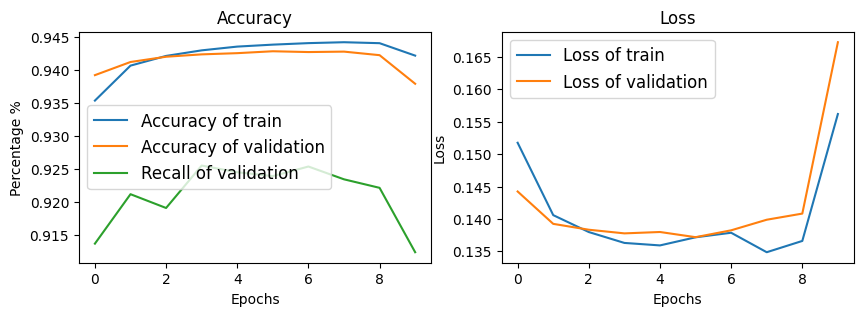

In [20]:
fig = plt.figure(figsize=(10,3))
x_arr = list(range(num_epochs))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, stat.acc_train, label="Accuracy of train")
ax.plot(x_arr, stat.acc_valid, label="Accuracy of validation")
ax.plot(x_arr, stat.rec_valid, label="Recall of validation")
ax.legend(fontsize=12)
# ax.set_ylim(.8, 1)
ax.set_title('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Percentage %')

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, stat.loss_train, label="Loss of train")
ax.plot(x_arr, stat.loss_valid, label="Loss of validation")
ax.legend(fontsize=12)
ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.show()

In [21]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.9122450916349945,
 'accuracy': 0.9377886527095968,
 'loss': 0.16783918841910653}

In [22]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,NELFQPTVSGIIQ,6.709604e-01,epitope
1,LHDLSKAELA,1.372976e-14,other
2,GVPNDKEFETFT,8.560386e-01,random
3,ERPYKCELCP,3.330221e-05,other
4,GGGRGGYGGGGP,9.830779e-01,epitope


711246 2227623


Text(0.5, 1.0, 'Distinguish non-epitopes, n = 2227623')

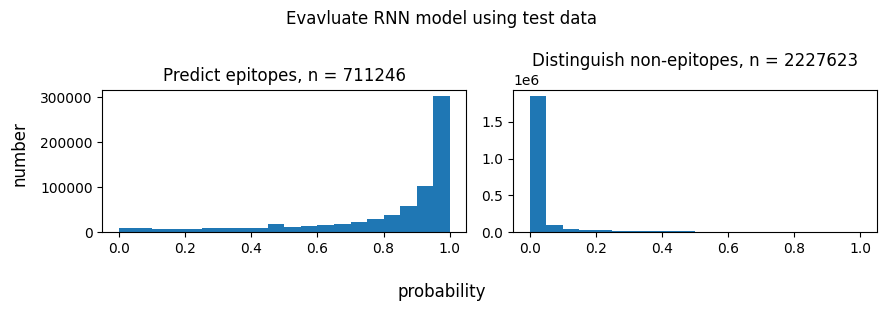

In [87]:
t = pred_test[pred_test['labels']=='epitope']['predict']
f = pred_test[~(pred_test['labels']=='epitope')]['predict']
print(len(t), len(f))

fig, ax = plt.subplots(1, 2, figsize=(9,3), layout='tight')
fig.suptitle('Evavluate RNN model using test data')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, bins=20)
ax[0].set_title(f'Predict epitopes, n = {len(t)}')
ax[1].hist(f, bins=20)
ax[1].set_title(f'Distinguish non-epitopes, n = {len(f)}')

In [29]:
# save model
torch.save(input_vocab, '../models/epitopes_rnn_vocab.pth')
torch.save(model.state_dict(), '../models/epitopes_rnn.pth')